In [1]:
import warnings
warnings.filterwarnings('ignore')

import argparse
import os, sys, importlib
from glob import glob
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import scipy

from utilities import reduced_parameter as red
from field.utils import profiling_rad
from field.electromagnetic import FreeVectorPotential, CavityVectorPotential
from matter.atoms import AtomsInBox
from calculator.calculator import Calculator

from utilities.etc import categorizing_result

import animation as an
from scipy import fft, signal
from analyze_tools.IR_DACF import calc_ACF, calc_FFT

from simulation.single import single_collision_simulation
import utilities.reduced_parameter as red

In [2]:
s = red.sigma_Ar_Xe
e = red.epsilon_Ar_Xe

re = s * 2 ** (1/6)
k = 4 * e * (156 * (s**12 / re**14) - 42 * (s**6 / re**8))
mu = red.mass_dict['Ar'] * red.mass_dict['Xe'] / (red.mass_dict['Ar'] + red.mass_dict['Xe'])
omega = np.sqrt(k / mu)

vib_freq = omega / (2 * np.pi * red.c * red.sigma)
vib_freq

22.766978335022763

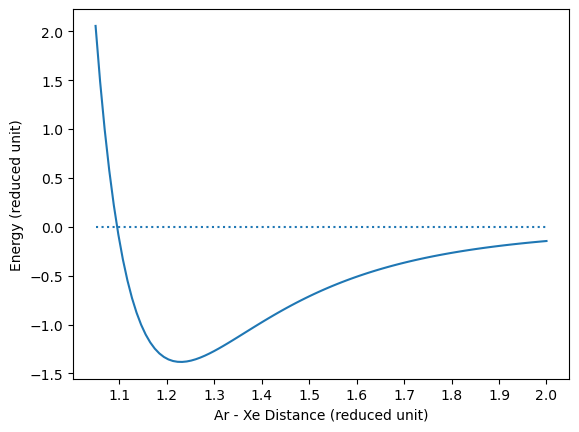

In [3]:
potential_function = lambda r:  4 * red.epsilon_Ar_Xe \
            * ( (red.sigma_Ar_Xe/r)**12 - (red.sigma_Ar_Xe/r)**6 )

fig,ax = plt.subplots()

r = np.linspace(1.05, 2.0, 100)
ax.plot(r, potential_function(r))
ax.hlines(0, min(r), max(r), linestyle = 'dotted')

ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.set_xlabel('Ar - Xe Distance (reduced unit)')
ax.set_ylabel('Energy (reduced unit)')

fig.savefig('figure/potential.jpeg',dpi = 600)

In [4]:
#
# Define paths to pickle files and functions
#

def assert_path(path):
    try: 
        assert os.path.isdir(path)
    except AssertionError:
        raise Exception("Path {} is not exist".format(path))

def field_spectra(result_dict, limit = None):
    rad_profile = []
    
    for i, rd in result_dict.items():

        if limit and i > limit : 
            continue
        
        Afield = rd["field"]
        
        rad_energy = red.convert_energy(np.array(Afield.history["energy"][-1]), "ev") 
        omega = red.convert_wavenumber(Afield.k_val)
        omega_profile, final_rad_profile = profiling_rad(omega, rad_energy)
        
        foo = np.argsort(omega_profile)
        omega_profile = np.array(omega_profile)[foo]
        final_rad_profile = np.array(final_rad_profile)[foo]
        
        rad_profile.append(final_rad_profile)
        
    rad_profile = np.mean(rad_profile, axis = 0)
    
    return omega_profile, np.array(rad_profile)

def fft_autocorr(t,dp_vel,h,windows='Gaussian'):
    autocorr = calc_ACF(dp_vel)
    yfft = calc_FFT(autocorr, windows)
    yfft = np.nan_to_num(yfft)
    intensity = np.sum(yfft, axis=1)[0:int(len(yfft)/2)]
    
    delta_t = red.convert_time(h) * 1e-12 * 3e10
    wvn = np.fft.fftfreq(len(yfft), delta_t)[0:int(len(yfft)/2)]
    
    return wvn, intensity

def dipole_spectra(
    atoms, h, time_frame = None, 
    quant = 'dipole_velocity', windows = 'Gaussian'):
    #h = result_dict['h']

    if time_frame: 
        ti, tf = time_frame
    dipole_velocity = np.sum(
        atoms.observable[quant], axis = 1)
    dp = np.array(dipole_velocity)
    #dp_vel = np.sum(
    #    result_dict['atoms'].observable['dipole'], axis = 1
    #)

    if time_frame: 
        time = np.array(atoms.observable['t'])
        time -= time[0]
        dp = dp[(time > ti) * (time < tf)]

    wavenumber, ir = fft_autocorr(time, dp, h, windows)

    if quant == 'dipole':
        ir *= wavenumber**2

    return np.array(wavenumber), np.array(ir)

In [133]:
Lxy = 3e7; Lz = 3e3
def get_ArXePair(d_arxe, v_ar = 0, h = 0, n_pairs = 1, Lxy=Lxy, Lz=Lz):
    """
    """
    atoms = AtomsInBox(
        Lxy = Lxy, Lz = Lz, cell_width = (1e6,1e2), 
        mass_dict = red.mass_dict)

    v_xe = - v_ar / 3

    for i in range(n_pairs):
        if i == 0:
            r0 = np.zeros(3)
        else:
            r0 = np.hstack(
                [
                    #np.random.uniform(-Lxy/2+10, Lxy/2-10, size = 2), 
                    np.zeros(2),
                    np.random.uniform(-Lz/2+10, Lz/2-10)]
            )
        atoms.add(
                elements = ["Ar"],
                r = np.array([[h,0.0,-d_arxe/2]]) + r0,
                r_dot = np.array([[0.0, 0.0, v_ar]])
                )
        
        atoms.add(
                elements = ["Xe"],
                r = np.array([[0,0.0,d_arxe/2]]) + r0,
                r_dot = np.array([[0.00, 0.00, v_xe]])
                )
    
    idxAr = atoms.element_idx(element = "Ar")
    idxXe = atoms.element_idx(element = "Xe")
    epsilon_mat, sigma_mat = red.generate_LJparam_matrix(idxAr = idxAr, idxXe = idxXe)
    
    # calculator to the atoms object
    atoms.add_calculator(
        calculator_class = Calculator,
        calculator_kwargs = {
            "epsilon": epsilon_mat, "sigma" : sigma_mat, 
            "positive_atom_idx" : idxXe, "negative_atom_idx" : idxAr,
            "mu0" : red.mu0, "d" : red.d0, "a" : red.a, 'd7':red.d7
        })
    
    atoms.update_distance()
    
    return atoms

def get_field(coup_str, mode = False, Lxy = Lxy, Lz = Lz):
    if mode == 'multi':
        k_vector_int = np.array(
            [[i,0,0] for i in range(1,100)]
            ,dtype=np.float64)
    elif isinstance(mode, int):
        k_vector_int = np.array([[mode,0,0]])
    elif isinstance(mode, list):
        k_vector_int = np.array(
            [[i,0,0] for i in mode], 
            dtype = np.float64)
    else:
        raise Exception('Mode have to be either "multi" or an integer!')
    
    amplitude = np.vstack([
        np.random.uniform(size = 2) * 1 + np.random.uniform(size = 2) * 1j
        for i in range(len(k_vector_int))
        ])
   
    Afield = CavityVectorPotential(
            k_vector_int = k_vector_int, amplitude = amplitude,
            Lxy = Lxy, Lz = Lz, constant_c = red.c, coupling_strength = coup_str * Lxy
            )

    return Afield
    

In [195]:
atoms = get_ArXePair(d_arxe = 4.00, h = 1.0 , v_ar = 0.03, n_pairs = 1)

field = get_field(mode = 'multi', coup_str = 20)
    
t, rd = single_collision_simulation(
    0, h = 1e-2, atoms = atoms, field = field, 
    max_steps = 20000, verbose = True)

Cycle: 0, iterations: 1, potential: -1.9440E-03
Cycle: 0, iterations: 2, potential: -1.9451E-03
Cycle: 0, iterations: 3, potential: -1.9462E-03
Cycle: 0, iterations: 4, potential: -1.9473E-03
Cycle: 0, iterations: 5, potential: -1.9484E-03
Cycle: 0, iterations: 6, potential: -1.9495E-03
Cycle: 0, iterations: 7, potential: -1.9506E-03
Cycle: 0, iterations: 8, potential: -1.9517E-03
Cycle: 0, iterations: 9, potential: -1.9529E-03
Cycle: 0, iterations: 10, potential: -1.9540E-03
Cycle: 0, iterations: 11, potential: -1.9551E-03
Cycle: 0, iterations: 12, potential: -1.9562E-03
Cycle: 0, iterations: 13, potential: -1.9573E-03
Cycle: 0, iterations: 14, potential: -1.9584E-03
Cycle: 0, iterations: 15, potential: -1.9596E-03
Cycle: 0, iterations: 16, potential: -1.9607E-03
Cycle: 0, iterations: 17, potential: -1.9618E-03
Cycle: 0, iterations: 18, potential: -1.9629E-03
Cycle: 0, iterations: 19, potential: -1.9641E-03
Cycle: 0, iterations: 20, potential: -1.9652E-03
Cycle: 0, iterations: 21, pot

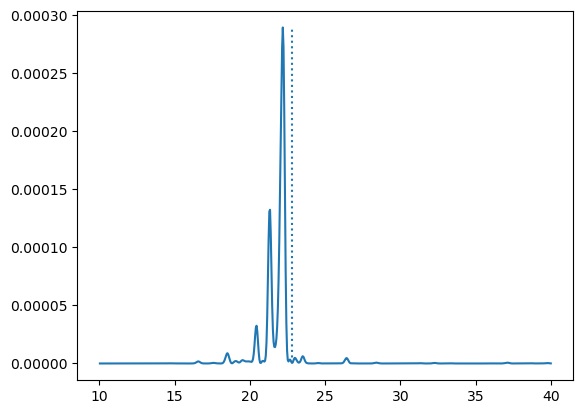

In [205]:
atoms = rd['atoms']

total_dipole = np.sum(atoms.observable['dipole'], axis = 1)
total_dipole_norm = np.sqrt(
    np.einsum('ni,ni->n', total_dipole, total_dipole))

fig,ax = plt.subplots()

wn, ir = dipole_spectra(
    atoms, h = 1e-2, time_frame = (0,np.inf),
    quant = 'dipole_velocity'
)

ir = ir[(wn < 40) * (wn > 10)]
wn = wn[(wn < 40) * (wn > 10)]

ax.plot(
    wn, ir
)

ax.vlines(vib_freq, min(ir), max(ir), linestyle = 'dotted')

In [22]:
total_dipole_norm > 0

array([ True,  True,  True, ...,  True,  True,  True])

In [ ]:
##################################
#"""
#Single pair of Ar-Xe
#Single mode @ resonance
#Examining the coupling strength
#"""
##################################

single_mode_atoms_dict = {}

for i, ct in enumerate([1, 10,30]):
    
    atoms = get_ArXePair(1.2, n_pairs = 1)
    
    field = get_field(mode = 23, coup_str = ct)
    
    t, rd = single_collision_simulation(
        0, h = 1e-2, atoms = atoms, field = field, 
        max_steps = 10000, verbose = False)
    atoms = rd['atoms']

    single_mode_atoms_dict.update({ct: atoms})
    

In [ ]:
fig,ax = plt.subplots()

for ct, atoms in single_mode_atoms_dict.items():
    
    wn, ir = dipole_spectra(
        atoms, h = 1e-2, time_frame = (0,1000),
        quant = 'dipole_velocity'
    )
    ir = smooth(ir[(wn < 25) * (wn > 20)])
    wn = wn[(wn < 25) * (wn > 20)]
    
    ax.plot(
        wn, ir, label = "Dipole scaling = {}L".format(ct),
        linestyle = 'dotted' if ct == 1 else None
    )

ax.set_xlabel('Wavenumber (1/cm)')
ax.set_ylabel('Intensity (arbitray unit)')
ax.legend()
fig.savefig('figure/single.jpeg',dpi=600)

In [ ]:
"""
Single pair of Ar-Xe
Multiple mode from 1->100
Examining the coupling strength
"""

multi_mode_atoms_dict = {}

for i, ct in enumerate([1, 10,30]):
    
    atoms = get_ArXePair(1.2)
    
    field = get_field(mode = 'multi', coup_str = ct)
    
    t, rd = single_collision_simulation(
        0, h = 1e-2, atoms = atoms, field = field, 
        max_steps = 10000, verbose = False)
    atoms = rd['atoms']

    multi_mode_atoms_dict.update({ct: atoms})
    

In [ ]:
fig,ax = plt.subplots()

for ct, atoms in multi_mode_atoms_dict.items():
    wn, ir = dipole_spectra(atoms, h = 1e-2, time_frame = (0,1000), quant = 'dipole_velocity')
    ir = ir[(wn < 26) * (wn > 20)]
    wn = wn[(wn < 26) * (wn > 20)]

    ax.plot(
        wn, ir, label = "Dipole scaling = {}L".format(ct),
        linestyle = 'dotted' if ct == 1 else None
    )

ax.set_xlabel('Wavenumber (1/cm)')
ax.set_ylabel('Intensity (arbitray unit)')
ax.legend()
fig.savefig('figure/multiple.jpeg',dpi=600)

In [ ]:
"""
Single pair of Ar-Xe
Single mode @ resonance
Examining the Ar-Xe initial distance
"""
single_mode_datoms_dict = {}

for i, d in enumerate([1.1, 1.15, 1.2, 1.3]):
    
    atoms = get_ArXePair(d)
    
    field = get_field(mode = 23, coup_str = 30)
    
    t, rd = single_collision_simulation(
        0, h = 1e-2, atoms = atoms, field = field, 
        max_steps = 20000, verbose = False)
    atoms = rd['atoms']

    single_mode_datoms_dict.update({d: atoms})
    

In [ ]:
fig,ax = plt.subplots(2, figsize = (6,8))

for d, atoms in single_mode_datoms_dict.items():
    
    wn, ir = dipole_spectra(atoms, h = 1e-2, time_frame = (0,1000))
    
    if d == 1.4 or d == 1.1: 
        i = 1
        ir = ir[(wn < 100) * (wn > 0)]
        wn = wn[(wn < 100) * (wn > 0)]
    else: 
        i = 0
        ir = ir[(wn < 45) * (wn > 18)]
        wn = wn[(wn < 45) * (wn > 18)]
    
    ax[i].plot(
        wn, ir, label = "Ar-Xe dist. = {}".format(d)
    )

#ax.set_xlabel('Wavenumber (1/cm)')
#ax.set_ylabel('Intensity (arbitray unit)')
ax[0].legend()
ax[1].legend()
fig.savefig('figure/single_distance.jpeg',dpi=600)

In [ ]:
"""
Single pair of Ar-Xe
Multiple mode from 1->100
Examining the Ar-Xe initial distance
"""
multi_mode_datoms_dict = {}

for i, d in enumerate([1.1, 1.15, 1.2, 1.3]):
    
    atoms = get_ArXePair(d)
    
    field = get_field(mode = 'multi', coup_str = 30)
    
    t, rd = single_collision_simulation(
        0, h = 1e-2, atoms = atoms, field = field, 
        max_steps = 10000, verbose = False)
    atoms = rd['atoms']

    multi_mode_datoms_dict.update({d: atoms})
    

In [ ]:
fig,ax = plt.subplots(2, figsize = (6,8))

for d, atoms in multi_mode_datoms_dict.items():
    
    wn, ir = dipole_spectra(atoms, h = 1e-2, time_frame = (0,1000), quant = 'dipole_velocity')
    
    if d == 1.4 or d == 1.1: 
        i = 1
        ir = ir[(wn < 30) * (wn > 15)]
        wn = wn[(wn < 30) * (wn > 15)]
    else: 
        i = 0
        ir = ir[(wn < 30) * (wn > 15)]
        wn = wn[(wn < 30) * (wn > 15)]
    
    ax[i].plot(
        wn, ir, label = "Ar-Xe dist. = {}".format(d)
    )

#ax.set_xlabel('Wavenumber (1/cm)')
#ax.set_ylabel('Intensity (arbitray unit)')
ax[0].legend()
ax[1].legend()
fig.savefig('figure/multi_distance.jpeg',dpi=600)

In [ ]:
"""
Multiple pair of Ar-Xe
Single mode @ resonance
Examining the coupling strength
"""

single_mode_atoms_dict = {}

np.random.seed(100)

for i, ct in enumerate([10, 20, 50]):
    
    atoms = get_ArXePair(1.21, n_pairs = 16)
    
    field = get_field(mode = 23, coup_str = ct)
    
    t, rd = single_collision_simulation(
        0, h = 1e-2, atoms = atoms, field = field, 
        max_steps = 10000, verbose = False)
    atoms = rd['atoms']

    single_mode_atoms_dict.update({ct: atoms})

In [ ]:
fig,ax = plt.subplots(3)

for i, (ct, atoms) in enumerate(single_mode_atoms_dict.items()):
    #if ct == 5:continue
    wn, ir = dipole_spectra(
        atoms, h = 1e-2, time_frame = (50,np.inf),
        quant = 'dipole_velocity', windows = 'BH'
    )
    ir = ir[(wn < 40) * (wn > 10)]
    wn = wn[(wn < 40) * (wn > 10)]
    
    ax[i].plot(
        wn, ir, label = "Dipole scaling = {}L".format(ct),
    )

#ax.set_xlabel('Wavenumber (1/cm)')
#ax.set_ylabel('Intensity (arbitray unit)')
ax[0].legend()
ax[1].legend()
ax[2].legend()
fig.savefig('figure/multicomplex_single.jpeg',dpi=600)

In [ ]:
atoms = single_mode_atoms_dict[5]
dpv = np.array(atoms.observable['dipole_velocity'])

i = 7
single_dpv = dpv[:,2*i,:] + dpv[:,2*i+1,:]
time = atoms.observable['t']

In [ ]:
wn, ir = fft_autocorr(time, single_dpv, 1e-2, windows = 'BH')

In [ ]:
fig,ax = plt.subplots()

ax.plot(wn,ir)
ax.set_xlim(10,30)

In [ ]:
R = np.array(atoms.trajectory['r'])

R[0,0,:] - R[0,1,:] 